In [81]:
import os
import shutil
import sys

import json

import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd
import implicit

from tqdm.notebook import tqdm

In [108]:
# Just choose the name of the dataset directory
dataset  = 'ml-20m'
DATA_DIR = '/Users/tomas/Documents/FEUP/Tese/data/' + dataset
PARSE_DATA_DIR = os.path.join(DATA_DIR, 'processed_70_10_20')

In [62]:
# K = 10
pre_meta_data_df = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'total_results_k_10.csv'), header=0)

In [109]:
# K = 20
pre_meta_data_df = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'total_results_k_20.csv'), header=0)

In [37]:
# K = 100
pre_meta_data_df = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'total_results_k_100.csv'), header=0)

In [110]:
pre_meta_data_df = pre_meta_data_df.drop('uid', 1)

In [117]:
pre_meta_data_df = pre_meta_data_df.drop('knn_tfidf_ndcg', 1)
pre_meta_data_df = pre_meta_data_df.drop('knn_cos_ndcg', 1)
pre_meta_data_df = pre_meta_data_df.drop('knn_bm25_ndcg', 1)

In [111]:
pre_meta_data_df['zeroes'] = 0.000001

In [123]:
pre_meta_data_df.head()

,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg,zeroes
0,0.000000,0.000000,0.0,0.000000,0.000001
1,0.746604,0.000000,0.0,0.373071,0.000001
2,0.000000,0.247014,0.0,0.333333,0.000001
3,0.000000,0.000000,0.0,0.000000,0.000001
4,0.272511,0.235409,0.0,0.371962,0.000001


In [119]:
pre_meta_data_dict = dict([(r[0], list(pre_meta_data_df.columns[np.argsort(list(r)[1::])])) \
    for r in list(pre_meta_data_df.to_records())])

In [47]:
pre_meta_data_dict

{0: ['als_ndcg',
  'most_popular_ndcg',
  'knn_cos_ndcg',
  'knn_tfidf_ndcg',
  'knn_bm25_ndcg',
  'zeroes',
  'bpr_ndcg',
  'lmf_ndcg'],
 1: ['bpr_ndcg',
  'knn_bm25_ndcg',
  'zeroes',
  'lmf_ndcg',
  'als_ndcg',
  'most_popular_ndcg',
  'knn_tfidf_ndcg',
  'knn_cos_ndcg'],
 2: ['most_popular_ndcg',
  'knn_cos_ndcg',
  'knn_tfidf_ndcg',
  'zeroes',
  'knn_bm25_ndcg',
  'als_ndcg',
  'lmf_ndcg',
  'bpr_ndcg'],
 3: ['lmf_ndcg',
  'most_popular_ndcg',
  'zeroes',
  'bpr_ndcg',
  'knn_cos_ndcg',
  'knn_tfidf_ndcg',
  'knn_bm25_ndcg',
  'als_ndcg'],
 4: ['bpr_ndcg',
  'zeroes',
  'knn_bm25_ndcg',
  'als_ndcg',
  'lmf_ndcg',
  'knn_tfidf_ndcg',
  'most_popular_ndcg',
  'knn_cos_ndcg'],
 5: ['most_popular_ndcg',
  'zeroes',
  'knn_cos_ndcg',
  'lmf_ndcg',
  'als_ndcg',
  'knn_tfidf_ndcg',
  'knn_bm25_ndcg',
  'bpr_ndcg'],
 6: ['bpr_ndcg',
  'zeroes',
  'lmf_ndcg',
  'knn_bm25_ndcg',
  'als_ndcg',
  'knn_tfidf_ndcg',
  'most_popular_ndcg',
  'knn_cos_ndcg'],
 7: ['zeroes',
  'lmf_ndcg',
  'mo

In [120]:
pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['fifth_place', 'fourth_place', 'third_place','second_place','first_place'])
#pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['eight_place', 'seventh_place', 'sixth_place', 'fifth_place', 'fourth_place', 'third_place','second_place','first_place'])
#pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['seventh_place', 'sixth_place', 'fifth_place', 'fourth_place', 'third_place','second_place','first_place'])

In [121]:
pre_meta_data.head(10)

,fifth_place,fourth_place,third_place,second_place,first_place
0,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg,zeroes
1,bpr_ndcg,lmf_ndcg,zeroes,most_popular_ndcg,als_ndcg
2,als_ndcg,lmf_ndcg,zeroes,bpr_ndcg,most_popular_ndcg
3,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg,zeroes
4,lmf_ndcg,zeroes,bpr_ndcg,als_ndcg,most_popular_ndcg
5,most_popular_ndcg,zeroes,als_ndcg,lmf_ndcg,bpr_ndcg
6,bpr_ndcg,lmf_ndcg,zeroes,most_popular_ndcg,als_ndcg
7,most_popular_ndcg,zeroes,lmf_ndcg,als_ndcg,bpr_ndcg
8,lmf_ndcg,zeroes,most_popular_ndcg,als_ndcg,bpr_ndcg
9,als_ndcg,bpr_ndcg,lmf_ndcg,zeroes,most_popular_ndcg


### Helper

In [89]:
def plot_stats(labels, values, title):
    """Plot histogram and pie chart  
        Args:
            labels: labels to be used in the plots 
            values: values to be ploted
            title: title of the plots

        Returns:
        two plots
    """
    # Create arrays for the plot
    x_pos = np.arange(len(labels))
    
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, values, align='center', alpha=0.8)
    ax.set_ylabel('count')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.show()
    
    fig_pie, ax_pie = plt.subplots()
    ax_pie.pie(values, labels=labels, autopct='%1.1f%%')
    ax_pie.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax_pie.set_title(title)


    plt.show()
    
    
    
    return

## Plots

#### Top Each place

--- plots of fifth_place  ---


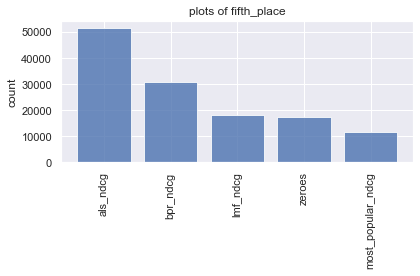

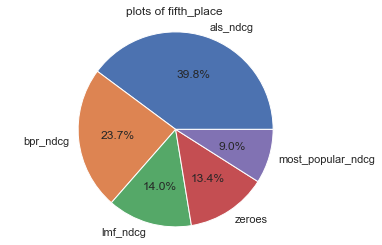

--- plots of fourth_place  ---


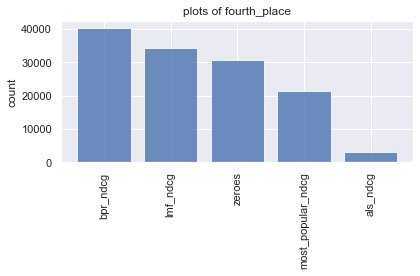

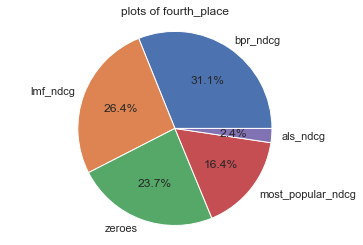

--- plots of third_place  ---


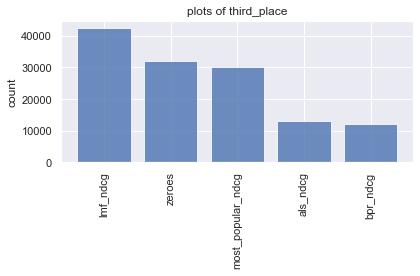

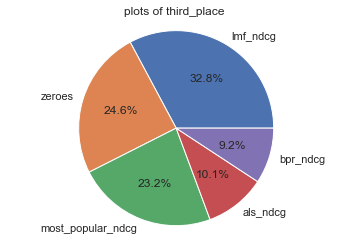

--- plots of second_place  ---


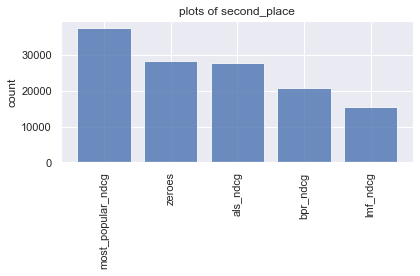

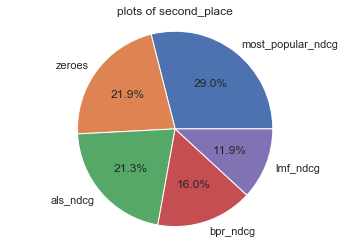

--- plots of first_place  ---


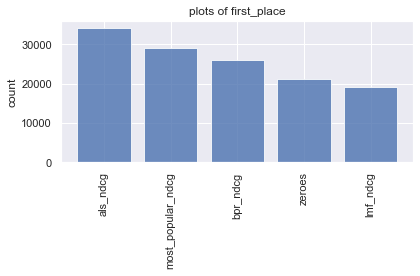

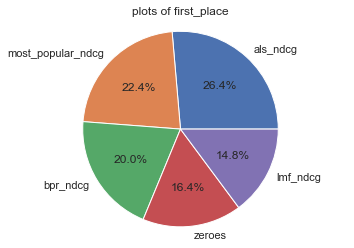

In [122]:
for col in pre_meta_data.columns:
    print('--- plots of', col , ' ---')
    x_place = pre_meta_data[col].value_counts().to_dict()
    plot_stats(x_place.keys(), x_place.values(), 'plots of '+ col)

In [ ]:

to
